<a href="https://colab.research.google.com/github/guilhermeterenciani/IA/blob/main/aula12_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
from torch import tensor
import numpy as np
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import optim
from torchsummary import summary

In [ ]:
batch_size = 128

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

ds_train = torchvision.datasets.MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)


dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)

test_ds = torchvision.datasets.MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 269150716.93it/s]

Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 23322236.01it/s]


Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 71410486.61it/s]

Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17178114.31it/s]


Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



In [ ]:
x,y = next(iter(dl_train))

In [ ]:
x.shape

torch.Size([128, 1, 28, 28])

# AutoEncoder MLP

In [ ]:
class AutoEncoderMLP(nn.Module):
    def __init__(self,input_size = 784,latent_dim=20):
        super(AutoEncoderMLP,self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size,90),
            nn.ReLU(inplace=True),
            nn.Linear(90,60),
            nn.ReLU(inplace=True),
            nn.Linear(60,40),
            nn.ReLU(inplace=True),
            nn.Linear(40,latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim,40),
            nn.ReLU(inplace=True),
            nn.Linear(40,60),
            nn.ReLU(inplace=True),
            nn.Linear(60,90),
            nn.ReLU(inplace=True),
            nn.Linear(90,784),
            nn.Tanh()
        )
        # encoder 784 -> 90 -> 60 -> 40 -> 20
        # funcao de ativacao -> nn.ReLU(inplace=True)
        # decoder 20 > 40 -> 60 -> 90 -> 784
        pass
    def forward(self,x):
        x = x.view(-1,1,784)
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(-1,1,28,28)
        return x


In [ ]:
model = AutoEncoderMLP()

In [ ]:
pred=model(x)

In [ ]:
pred.shape

torch.Size([128, 1, 28, 28])

In [ ]:
summary(model,(1,28,28),device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 90]          70,650
              ReLU-2                [-1, 1, 90]               0
            Linear-3                [-1, 1, 60]           5,460
              ReLU-4                [-1, 1, 60]               0
            Linear-5                [-1, 1, 40]           2,440
              ReLU-6                [-1, 1, 40]               0
            Linear-7                [-1, 1, 20]             820
            Linear-8                [-1, 1, 40]             840
              ReLU-9                [-1, 1, 40]               0
           Linear-10                [-1, 1, 60]           2,460
             ReLU-11                [-1, 1, 60]               0
           Linear-12                [-1, 1, 90]           5,490
             ReLU-13                [-1, 1, 90]               0
           Linear-14               [-1,

# AutoEncoder Conv

In [ ]:
class View(nn.Module):
    def __init__(self, shape):
        super(View,self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(*self.shape)

In [ ]:
v = View((-1,1,7,7))

In [ ]:
class AutoEncoderConv(nn.Module):
    def __init__(self,hidden_size=20,latent_dim=20):
        super(AutoEncoderConv,self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels = hidden_size, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=hidden_size,out_channels = hidden_size*2,kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(in_features=hidden_size*2*7*7,out_features=latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features = latent_dim,out_features = hidden_size*2*7*7),
            View((-1,hidden_size*2,7,7)),
            nn.ConvTranspose2d(in_channels = hidden_size*2,out_channels=hidden_size,kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels = hidden_size,out_channels=1            ,kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
model = AutoEncoderConv(latent_dim=40)

In [ ]:
x,y = next(iter(dl_train))

In [ ]:
x.shape

torch.Size([128, 1, 28, 28])

In [ ]:
convimg = transforms.ToPILImage()

In [ ]:
nx = x+torch.randn(x.shape)*0.01

In [ ]:
convimg(x[1])

In [ ]:
convimg(x[1]+torch.randn(x[1].shape)*0.01)

# Treinamento

In [ ]:
criterion = nn.MSELoss()
opt = optim.Adam(model.parameters())

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda')

In [ ]:
model.to(device)

AutoEncoderConv(
  (encoder): Sequential(
    (0): Conv2d(1, 20, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(20, 40, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=1960, out_features=40, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=40, out_features=1960, bias=True)
    (1): View()
    (2): ConvTranspose2d(40, 20, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(20, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): Tanh()
  )
)

In [ ]:
torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='Tesla K80', major=3, minor=7, total_memory=11441MB, multi_processor_count=13)

In [ ]:
epochs = 20
avg_loss = []
for epoch in range(epochs):
    epoch_loss =[]
    for x,y in dl_train:
        xr = x+torch.randn(x.shape)*0.01
        xr = xr.to(device)
        x = x.to(device)
        pred = model(xr)
        vloss = criterion(x,pred)
        vloss.backward()
        opt.step()
        opt.zero_grad()
        epoch_loss.append(vloss.cpu().item())
    avg_loss.append(np.mean(epoch_loss))
    print("[%d/%d] %f"%(epoch,epochs,avg_loss[-1]))



[0/20] 0.109885
[1/20] 0.027855
[2/20] 0.021946
[3/20] 0.019453
[4/20] 0.017995
[5/20] 0.016904
[6/20] 0.016106
[7/20] 0.015449
[8/20] 0.014923
[9/20] 0.014473
[10/20] 0.014120
[11/20] 0.013780
[12/20] 0.013509
[13/20] 0.013261
[14/20] 0.013043
[15/20] 0.012857
[16/20] 0.012712
[17/20] 0.012549
[18/20] 0.012416
[19/20] 0.012280


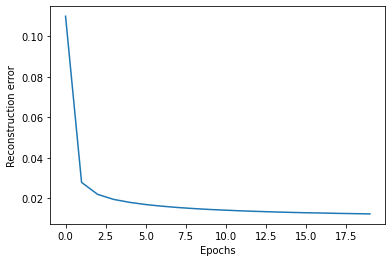

In [ ]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(avg_loss)
plt.xlabel('Epochs')
plt.ylabel('Reconstruction error')
plt.show()

Original images


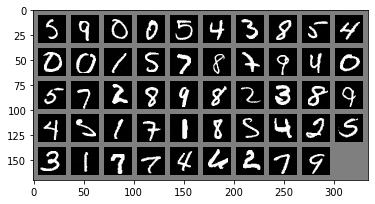

Autoencoder reconstruction:


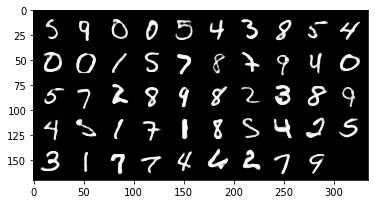

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

model.eval()


def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():

        images = images.to(device)
        images = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images, labels = iter(test_dl).next()
imagesr = images+torch.randn(images.shape)*0.02

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(imagesr[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the autoencoder
print('Autoencoder reconstruction:')
visualise_output(imagesr, model)

In [ ]:
images.shape

torch.Size([128, 1, 28, 28])

In [ ]:
convimg(images[0])

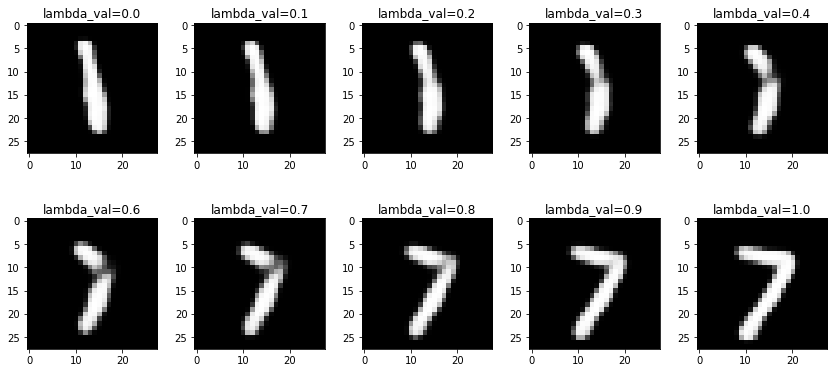

In [ ]:
model.eval()

def interpolation(lambda1, model, img1, img2):

    with torch.no_grad():

        # latent vector of first image
        img1 = img1.to(device)
        latent_1 = model.encoder(img1)

        # latent vector of second image
        img2 = img2.to(device)
        latent_2 = model.encoder(img2)

        # interpolation of the two latent vectors
        inter_latent = lambda1 * latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        inter_image = model.decoder(inter_latent)
        inter_image = inter_image.cpu()

    return inter_image

# sort part of test set by digit
digits = [[] for _ in range(10)]
for img_batch, label_batch in test_dl:
    for i in range(img_batch.size(0)):
        digits[label_batch[i]].append(img_batch[i:i+1])
    if sum(len(d) for d in digits) >= 1000:
        break;

# interpolation lambdas
lambda_range=np.linspace(0,1,10)

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    inter_image=interpolation(float(l), model, digits[7][0], digits[1][0])

    inter_image = to_img(inter_image)

    image = inter_image.numpy()

    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))

plt.show()

In [ ]:
autoencoder = model

In [ ]:
latent_dims = 40

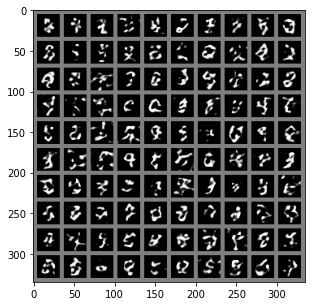

In [ ]:
autoencoder.eval()

with torch.no_grad():
    # approx. fit a multivariate Normal distribution (with diagonal cov.) to the latent vectors of a random part of the test set
    images, labels = iter(test_dl).next()
    images = images.to(device)
    latent = autoencoder.encoder(images)
    latent = latent.cpu()

    mean = latent.mean(dim=0)
    std = (latent - mean).pow(2).mean(dim=0).sqrt()

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, latent_dims)*std + mean

    # reconstruct images from the latent vectors
    latent = latent.to(device)
    img_recon = autoencoder.decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(5, 5))
    show_image(torchvision.utils.make_grid(img_recon[:100],10,5))
    plt.show()